In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

from keras.models import Sequential
from keras.layers import Dense

from google.colab import drive
tf.__version__

'2.4.1'

In [8]:
#Mounting Google drive and reading data from csv
#drive.mount('/content/drive')

data=pd.read_csv('/content/drive/MyDrive/IMDB/IMDB_Dataset.csv')

2a. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

In [9]:
#Printing 3 movie reviews from each class of the dataset for sanity check

print((data.loc[data['sentiment'] == 'positive']).head(3))
print('\n\n')
print((data.loc[data['sentiment'] == 'negative']).head(3))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive



                                              review sentiment
3  Basically there's a family where a little boy ...  negative
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative


2c. Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries)

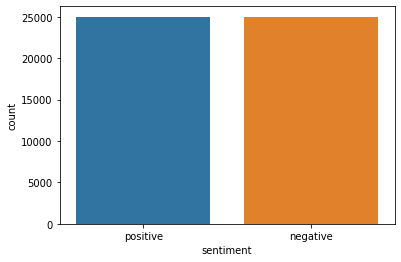

In [10]:
#Plot a bar graph of class distribution in dataset using seaborn library
import seaborn as sns
sns.countplot(x = data['sentiment'])

3a. Cleaning up of data before splitting the data (Data pre-processing)

In [11]:
data['sentiment']= data['sentiment'].map({'positive':1,'negative':0})
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [12]:
data2 = data.copy()
data3 = data.copy()

2d. Print the shapes of train and test data.

In [13]:
#Splitting data for train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data['review'],data['sentiment'],test_size = 0.3,random_state = 90)

In [14]:
#Printing shapes to train and test datas
print('Shape of Train data (X_Train, Y_Train):', X_train.shape, Y_train.shape)
print('Shape of Test data (X_test, Y_Test):', X_test.shape, Y_test.shape)

Shape of Train data (X_Train, Y_Train): (35000,) (35000,)
Shape of Test data (X_test, Y_Test): (15000,) (15000,)


In [15]:
from tensorflow.keras.callbacks import Callback
import time

class TimeHistory(Callback):

    def on_train_begin(self, logs={}):

        self.times = []

    def on_epoch_begin(self, batch, logs={}):

        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):

        self.times.append(time.time() - self.epoch_time_start)

3b, 3c and 4. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. And Model Building

In [16]:
#Pre-trained embedded model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string, trainable=True)

In [17]:
#Building the model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, kernel_regularizer='l2', activation='relu', input_shape=(10000,)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, kernel_regularizer='l2', activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, kernel_regularizer='l2', activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, kernel_regularizer='l2', activation='sigmoid'))
model.summary()
#Softmax as activation function for output layer is giving very low accuracy around 50%

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

5. Model Compilation

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

6. Model Training

In [19]:
history = model.fit(X_train, np.array(Y_train), batch_size=512, epochs=3, validation_split=0.3, shuffle=True)

Epoch 1/3
48/48 [==============================] - 82s 2s/step - loss: 1.1970 - accuracy: 0.5055 - val_loss: 1.0372 - val_accuracy: 0.6416
Epoch 2/3
48/48 [==============================] - 64s 1s/step - loss: 0.9966 - accuracy: 0.5686 - val_loss: 0.8883 - val_accuracy: 0.7788
Epoch 3/3
48/48 [==============================] - 64s 1s/step - loss: 0.8647 - accuracy: 0.6379 - val_loss: 0.7665 - val_accuracy: 0.8330


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

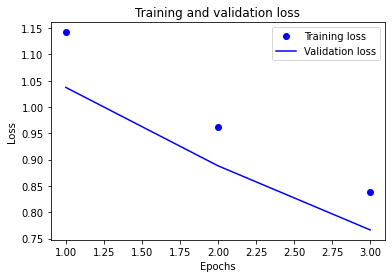

In [21]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

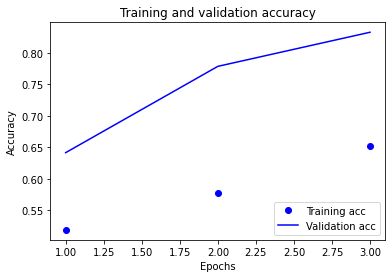

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [23]:
validation_dataset = history.model.output
print(validation_dataset)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")


7. Model Evaluation

In [24]:
test_loss,test_accuracy = model.evaluate(X_test,Y_test, batch_size=512)

print("Loss: ", test_loss)
print("Accuracy: ", test_accuracy)

30/30 [==============================] - 1s 36ms/step - loss: 0.7663 - accuracy: 0.8357
Loss:  0.7663326859474182
Accuracy:  0.8356666564941406


In [25]:
pre_cls=(model.predict(X_test) > 0.5).astype("int32")
cm1 = confusion_matrix(Y_test,pre_cls)
print('Confusion Matrix : \n')
print(cm1)

Confusion Matrix : 

[[6082 1490]
 [ 975 6453]]


In [26]:
classification_report(Y_test,pre_cls)   

'              precision    recall  f1-score   support\n\n           0       0.86      0.80      0.83      7572\n           1       0.81      0.87      0.84      7428\n\n    accuracy                           0.84     15000\n   macro avg       0.84      0.84      0.84     15000\nweighted avg       0.84      0.84      0.84     15000\n'

In [27]:
#Printing incorrectly classified data
incorrectly_classified = X_test[Y_test != pre_cls.reshape(-1,)]
print(incorrectly_classified)


20880    Just watched on UbuWeb this early experimental...
11919    "Rival reporters Pat Morgan (Ginger Rogers) an...
10592    I think my summary sums it up. I found it inan...
28338    Christopher Lee is one of my favorite actors! ...
48800    The Three Stooges in a feature length western ...
                               ...                        
29105    I have to confess I fell into the cynical trap...
30095    Poor geeky Marty (Simon Scuddamore) gets horri...
5681     This show was appreciated by critics and those...
14138    I just finished watching this movie. I was ver...
30264    Cinematography--Compared to 'The Wrestler,' a ...
Name: review, Length: 2465, dtype: object


Hyperparameter Tuning

 Second model by changing Network Depth (no of hidden layers and hidden units for each layer)

In [28]:
X2_train,X2_test,Y2_train,Y2_test = train_test_split(data2['review'],data2['sentiment'],test_size = 0.3,random_state = 90)

In [29]:
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(8, kernel_regularizer='l2', activation='relu'))

model2.add(tf.keras.layers.Dense(8, kernel_regularizer='l2', activation='relu'))

model2.add(tf.keras.layers.Dense(1, kernel_regularizer='l2', activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 124,643,801
Trainable params: 124,643,801
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
history2 = model2.fit(X2_train, np.array(Y2_train), batch_size=512, epochs=3, validation_split=0.2, shuffle=True)

Epoch 1/3
55/55 [==============================] - 74s 1s/step - loss: 0.8795 - accuracy: 0.6442 - val_loss: 0.6577 - val_accuracy: 0.8261
Epoch 2/3
55/55 [==============================] - 72s 1s/step - loss: 0.6028 - accuracy: 0.8434 - val_loss: 0.5167 - val_accuracy: 0.8620
Epoch 3/3
55/55 [==============================] - 72s 1s/step - loss: 0.4605 - accuracy: 0.8891 - val_loss: 0.4592 - val_accuracy: 0.8709


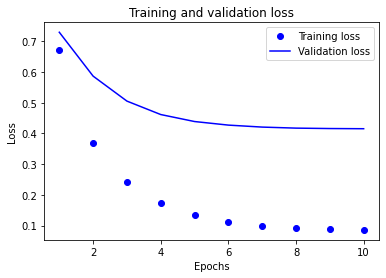

In [ ]:
history_dict2 = history2.history
acc2 = history_dict2['accuracy']
val_acc2 = history_dict['val_accuracy']
loss2 = history_dict['loss']
val_loss2 = history_dict['val_loss']

epochs2 = range(1, len(acc2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs2, loss2, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

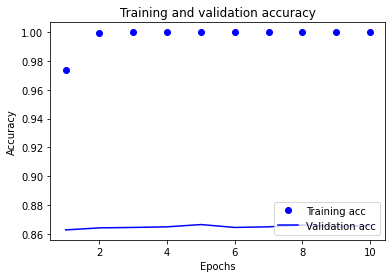

In [ ]:
plt.plot(epochs2, acc2, 'bo', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
test_loss2,test_accuracy2 = model2.evaluate(X2_test,Y2_test, batch_size=512)

print("Loss: ", test_loss2)
print("Accuracy: ", test_accuracy2)

30/30 [==============================] - 1s 25ms/step - loss: 0.4229 - accuracy: 0.8760
Loss:  0.4229259192943573
Accuracy:  0.8759999871253967


In [ ]:
# Third model by changing Optimizer

In [ ]:
X3_train,X3_test,Y3_train,Y3_test = train_test_split(data3['review'],data3['sentiment'],test_size = 0.3,random_state = 90)

In [ ]:
model3 = tf.keras.Sequential()
model3.add(hub_layer)
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(32, kernel_regularizer='l2', activation='relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(1, kernel_regularizer='l2', activation='sigmoid'))

model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

#model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(X3_train, np.array(Y3_train), batch_size=512, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
55/55 [==============================] - 3s 43ms/step - loss: 0.4983 - accuracy: 0.8870 - val_loss: 0.1889 - val_accuracy: 0.8651
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0815 - accuracy: 0.9994 - val_loss: 0.1326 - val_accuracy: 0.8660
Epoch 3/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0480 - accuracy: 0.9992 - val_loss: 0.1290 - val_accuracy: 0.8666
Epoch 4/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0454 - accuracy: 0.9995 - val_loss: 0.1285 - val_accuracy: 0.8664
Epoch 5/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0452 - accuracy: 0.9998 - val_loss: 0.1284 - val_accuracy: 0.8656
Epoch 6/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0448 - accuracy: 0.9996 - val_loss: 0.1281 - val_accuracy: 0.8660
Epoch 7/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0447 - accuracy: 0.9997 - val_loss: 0.1280 - val_accuracy: 0.8664
Epoch 8/10
55

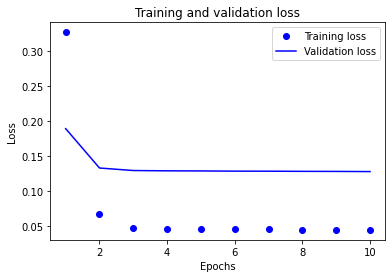

In [ ]:
history_dict3 = history3.history
acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs3 = range(1, len(acc3) + 1)

# "bo" is for "blue dot"
plt.plot(epochs3, loss3, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs3, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

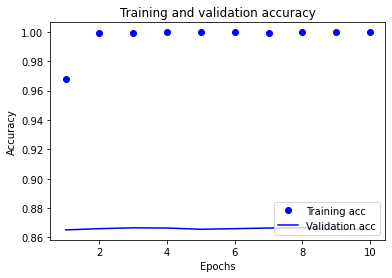

In [ ]:
plt.plot(epochs3, acc3, 'bo', label='Training acc')
plt.plot(epochs3, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
test_loss3,test_accuracy3 = model3.evaluate(X3_test,Y3_test, batch_size=512)

print("Loss: ", test_loss3)
print("Accuracy: ", test_accuracy3)

30/30 [==============================] - 1s 24ms/step - loss: 0.1226 - accuracy: 0.8750
Loss:  0.12259557843208313
Accuracy:  0.875
